## Import Data

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('traindrug.csv',encoding = "ISO-8859-1")
data = df.values[:, 0]
labels = df.values[:, 1]

testDf = pd.read_csv('testdrug.csv')
testData = testDf.values[:, 0]
testLabels = testDf.values[:, 1]

## Word2Vec and GloVe

In [92]:
from gensim.models import KeyedVectors
import re

file = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(file, binary=True, limit=50000)
word2vec_vectors = word2vec.wv

gloveFile = 'glove.6B.300d.txt.word2vec'
glove = KeyedVectors.load_word2vec_format(gloveFile, binary=False, limit=50000)
glove_vectors = glove.wv

<ipython-input-92-668db1155db1>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word2vec_vectors = word2vec.wv
<ipython-input-92-668db1155db1>:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors = glove.wv


In [93]:
def text2vec(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in word2vec_vectors:
                temp.append(word2vec[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

## Keras Imports

In [95]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, Embedding, LSTM
from keras import optimizers
from keras.layers.embeddings import Embedding
from keras import initializers
from keras.regularizers import l1
import tensorflow
import matplotlib.pyplot as plt

tensorflow.random.set_seed(0)
np.random.seed(0)

In [132]:
testLabels = np.asarray(testLabels).astype(np.float32)
labels = np.asarray(labels).astype(np.float32)

## Tokenization for Sequences

In [97]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(data)
token_list_train = tokenizer.texts_to_sequences(data)
token_list_test = tokenizer.texts_to_sequences(testData)
num_words = len(tokenizer.word_index)+1

In [98]:
length = []
for x in data:
    length.append(len(x.split()))
max_length = max(length)

In [99]:
x_train_seq = pad_sequences(token_list_train, maxlen=max_length)
x_test_seq = pad_sequences(token_list_test, maxlen=max_length)

In [100]:
x_test_seq.shape
x_test_seq=np.asarray(x_test_seq).astype(np.float32)
x_train_seq=np.asarray(x_train_seq).astype(np.float32)
y_test=np.asarray(testLabels).astype(np.float32)
y_train=np.asarray(labels).astype(np.float32)

In [101]:
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in word2vec_vectors:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector

Epoch 1/50
32/32 - 2s - loss: 9.1591 - mse: 2.7347 - mae: 1.3606 - val_loss: 7.2796 - val_mse: 1.0835 - val_mae: 0.8701
Epoch 2/50
32/32 - 2s - loss: 7.4905 - mse: 1.5476 - mae: 1.0030 - val_loss: 6.5959 - val_mse: 0.9524 - val_mae: 0.8213
Epoch 3/50
32/32 - 2s - loss: 6.6500 - mse: 1.2878 - mae: 0.9134 - val_loss: 5.9217 - val_mse: 0.8780 - val_mae: 0.7914
Epoch 4/50
32/32 - 2s - loss: 5.8797 - mse: 1.1172 - mae: 0.8730 - val_loss: 5.3523 - val_mse: 0.9063 - val_mae: 0.8090
Epoch 5/50
32/32 - 2s - loss: 5.2376 - mse: 1.0651 - mae: 0.8408 - val_loss: 4.7116 - val_mse: 0.8412 - val_mae: 0.7794
Epoch 6/50
32/32 - 2s - loss: 4.5123 - mse: 0.8960 - mae: 0.7771 - val_loss: 4.0249 - val_mse: 0.6825 - val_mae: 0.6898
Epoch 7/50
32/32 - 2s - loss: 4.0367 - mse: 0.9181 - mae: 0.7803 - val_loss: 3.5364 - val_mse: 0.6604 - val_mae: 0.6832
Epoch 8/50
32/32 - 2s - loss: 3.4680 - mse: 0.7880 - mae: 0.7189 - val_loss: 3.1583 - val_mse: 0.6831 - val_mae: 0.7030
Epoch 9/50
32/32 - 2s - loss: 3.0431 - m

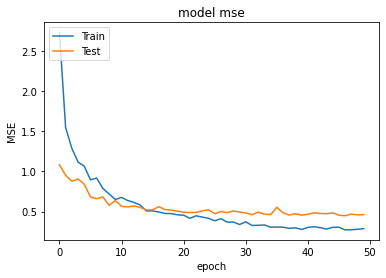

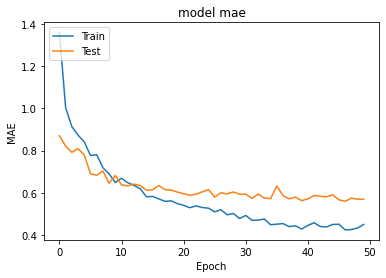

0.46318408846855164
0.5693535208702087


In [137]:
cnn_1 = Sequential()
cnn_1.add(Embedding(num_words, x_train_seq.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
init_he_u = initializers.he_uniform(seed=None)
cnn_1.add(Conv1D(128, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(GlobalMaxPooling1D())
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(32, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(10, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(Flatten())
cnn_1.add(Dense(1, activation='linear', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
history = cnn_1.fit(x_train_seq, labels, validation_data=(x_test_seq, testLabels), epochs=50, batch_size=32, verbose=2, shuffle=True)

_, mse, mae = cnn_1.evaluate(x_test_seq, testLabels)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(mse)
print(mae)

Accuracy: 0.502


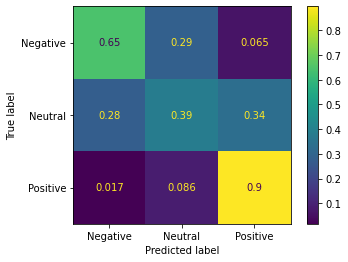

In [138]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
preds = cnn_1.predict(x_test_seq)
preds = np.around(preds)
acc = accuracy_score(preds, testLabels)
print('Accuracy: ' + str(acc))

cm = confusion_matrix(preds, testLabels, normalize='true')
disLabels = ['Negative', 'Neutral', 'Positive']
dis = ConfusionMatrixDisplay(cm, display_labels=disLabels)
dis.plot()
plt.show()

## Task 2.2

In [108]:
from keras.utils import to_categorical

encTrainLabels = to_categorical(labels-1, num_classes=3)
encTestLabels = to_categorical(testLabels-1, num_classes=3)

Epoch 1/50
32/32 - 2s - loss: 6.6208 - acc: 0.3330 - val_loss: 5.4013 - val_acc: 0.3380
Epoch 2/50
32/32 - 2s - loss: 4.4046 - acc: 0.3780 - val_loss: 3.4110 - val_acc: 0.3500
Epoch 3/50
32/32 - 2s - loss: 2.7594 - acc: 0.4030 - val_loss: 2.2098 - val_acc: 0.4360
Epoch 4/50
32/32 - 2s - loss: 1.9600 - acc: 0.3830 - val_loss: 1.7580 - val_acc: 0.3700
Epoch 5/50
32/32 - 2s - loss: 1.6802 - acc: 0.3850 - val_loss: 1.6274 - val_acc: 0.3860
Epoch 6/50
32/32 - 2s - loss: 1.5909 - acc: 0.3930 - val_loss: 1.5516 - val_acc: 0.4260
Epoch 7/50
32/32 - 2s - loss: 1.5364 - acc: 0.4180 - val_loss: 1.5171 - val_acc: 0.4360
Epoch 8/50
32/32 - 2s - loss: 1.5024 - acc: 0.4210 - val_loss: 1.4802 - val_acc: 0.4420
Epoch 9/50
32/32 - 2s - loss: 1.4619 - acc: 0.4330 - val_loss: 1.4408 - val_acc: 0.4620
Epoch 10/50
32/32 - 2s - loss: 1.4340 - acc: 0.4460 - val_loss: 1.4223 - val_acc: 0.4420
Epoch 11/50
32/32 - 2s - loss: 1.4051 - acc: 0.4830 - val_loss: 1.3828 - val_acc: 0.4960
Epoch 12/50
32/32 - 2s - loss:

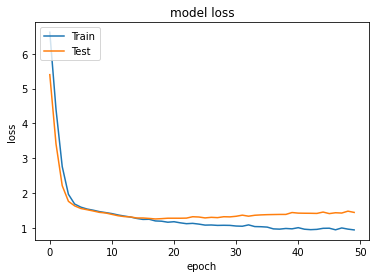

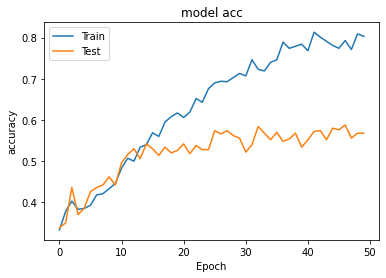

1.4390944242477417
0.5680000185966492


In [141]:
cnn_2 = Sequential()
cnn_2.add(Embedding(num_words, x_train_seq.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
init_he_u = initializers.he_uniform(seed=None)
cnn_2.add(Conv1D(128, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_2.add(GlobalMaxPooling1D())
cnn_2.add(Dropout(0.5))
cnn_2.add(Dense(32, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_1.add(Dropout(0.5))
cnn_2.add(Dense(10, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_2.add(Flatten())
cnn_2.add(Dense(3, activation='softmax', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
cnn_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn_2.fit(x_train_seq, encTrainLabels, validation_data=(x_test_seq, encTestLabels), epochs=50, batch_size=32, verbose=2, shuffle=True)

loss, acc = cnn_2.evaluate(x_test_seq, encTestLabels)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(loss)
print(acc)

Accuracy: 0.568


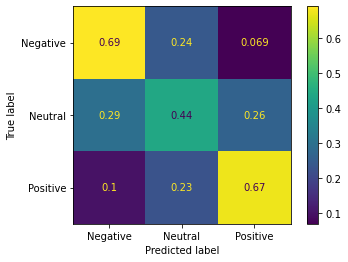

In [142]:
preds = cnn_2.predict(x_test_seq)
preds = np.argmax(preds, 1)
acc = accuracy_score(preds, testLabels-1)
print('Accuracy: ' + str(acc))

cm = confusion_matrix(preds, testLabels-1, normalize='true')
disLabels = ['Negative', 'Neutral', 'Positive']
dis = ConfusionMatrixDisplay(cm, display_labels=disLabels)
dis.plot()
plt.show()